# 2018170825 이주예 assignment 4

In [142]:
library(tree)
library(Epi)
library(party)
library(pROC)
library(ROCR)
library(tree)
library(ROCR)
library(ggplot2)
library(foreign)
library(rpart)
library(rpart.plot)
library(dplyr)
library(purrr)
library(nnet)
library(corrplot)
library(rattle)

Warning message:
"package 'rattle' was built under R version 4.0.5"
Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.



In [94]:
perf_eval <- function(cm){
  
  # True positive rate: TPR (Recall)
  TPR <- cm[2,2]/sum(cm[2,])
  # Precision
  PRE <- cm[2,2]/sum(cm[,2])
  # True negative rate: TNR
  TNR <- cm[1,1]/sum(cm[1,])
  # Simple Accuracy
  ACC <- (cm[1,1]+cm[2,2])/sum(cm)
  # Balanced Correction Rate
  BCR <- sqrt(TPR*TNR)
  # F1-Measure
  F1 <- 2*TPR*PRE/(TPR+PRE)
  
  return(c(TPR,TNR,PRE, ACC, BCR, F1))
}


# Performance table for A7
Perf_Table_total <- matrix(0, nrow =4, ncol =6)
rownames(Perf_Table_total) <- c("D1_LR",  "D1_Decision Tree", "D2_LR" ,  "D2_Decision Tree")
colnames(Perf_Table_total) <- c("TPR", "Precision", "TNR", "Accuracy", "BCR", "F1-Measure")


In [95]:
Perf_Table_total

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
D1_LR,0,0,0,0,0,0
D1_Decision Tree,0,0,0,0,0,0
D2_LR,0,0,0,0,0,0
D2_Decision Tree,0,0,0,0,0,0


# A1

고른 data set : [adult data set : 어른이 되서 일년에 50k 이상 버는가? ](https://archive.ics.uci.edu/ml/datasets/adult)

위 데이터를 고른 이유는 확인해 보고 싶은 가설이 있기 때문입니다

1. 학력과 income은 언제나 양의 상관관계를 갖는가?
2. 남/여의 유의미한 income차이가 있는가?

## EDA

In [171]:
data <- read.csv("adult.csv")

In [172]:
str(data)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  90 82 66 54 41 34 38 74 68 41 ...
 $ workclass     : chr  "?" "Private" "?" "Private" ...
 $ fnlwgt        : int  77053 132870 186061 140359 264663 216864 150601 88638 422013 70037 ...
 $ education     : chr  "HS-grad" "HS-grad" "Some-college" "7th-8th" ...
 $ education.num : int  9 9 10 4 10 9 6 16 9 10 ...
 $ marital.status: chr  "Widowed" "Widowed" "Widowed" "Divorced" ...
 $ occupation    : chr  "?" "Exec-managerial" "?" "Machine-op-inspct" ...
 $ relationship  : chr  "Not-in-family" "Not-in-family" "Unmarried" "Unmarried" ...
 $ race          : chr  "White" "White" "Black" "White" ...
 $ sex           : chr  "Female" "Female" "Female" "Female" ...
 $ capital.gain  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ capital.loss  : int  4356 4356 4356 3900 3900 3770 3770 3683 3683 3004 ...
 $ hours.per.week: int  40 18 40 40 40 45 40 20 40 60 ...
 $ native.country: chr  "United-States" "United-States" "United-States" "United-States" 

기존에 ?값을 다 na로 바꾼다음 na값을 포함하는 row를 모두 지웠습니다.

In [173]:
# ? --> na
data[ data == "?" ] <- NA
str(data)
data<-data[complete.cases(data), ]

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  90 82 66 54 41 34 38 74 68 41 ...
 $ workclass     : chr  NA "Private" NA "Private" ...
 $ fnlwgt        : int  77053 132870 186061 140359 264663 216864 150601 88638 422013 70037 ...
 $ education     : chr  "HS-grad" "HS-grad" "Some-college" "7th-8th" ...
 $ education.num : int  9 9 10 4 10 9 6 16 9 10 ...
 $ marital.status: chr  "Widowed" "Widowed" "Widowed" "Divorced" ...
 $ occupation    : chr  NA "Exec-managerial" NA "Machine-op-inspct" ...
 $ relationship  : chr  "Not-in-family" "Not-in-family" "Unmarried" "Unmarried" ...
 $ race          : chr  "White" "White" "Black" "White" ...
 $ sex           : chr  "Female" "Female" "Female" "Female" ...
 $ capital.gain  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ capital.loss  : int  4356 4356 4356 3900 3900 3770 3770 3683 3683 3004 ...
 $ hours.per.week: int  40 18 40 40 40 45 40 20 40 60 ...
 $ native.country: chr  "United-States" "United-States" "United-States" "United-States" ...


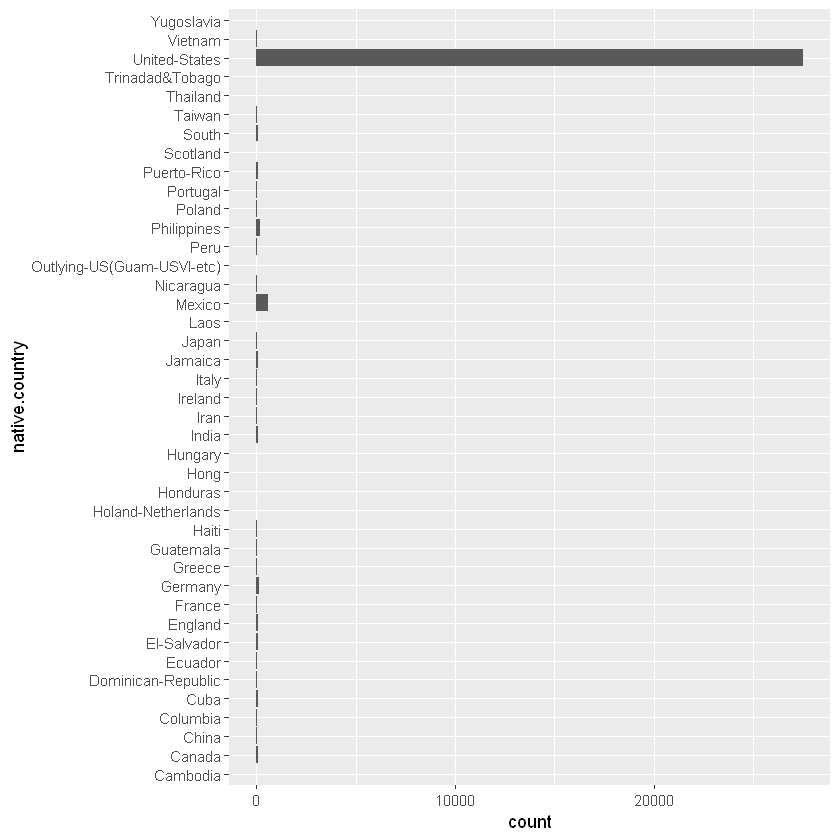

In [174]:
ggplot(data=data, aes(x=native.country))+geom_bar() + coord_flip()

너무 United States 만 많은 inbalaced data이기 때문에 그냥 united states 만 뽑아서 분석하겠습니다.

In [175]:
data<- data %>% filter(native.country == "United-States" )
str(data)

# usa 만 있으니 native.country column을 지우겠습니다
data <- data[,-14]

'data.frame':	27504 obs. of  15 variables:
 $ age           : int  82 54 41 34 38 74 68 45 38 52 ...
 $ workclass     : chr  "Private" "Private" "Private" "Private" ...
 $ fnlwgt        : int  132870 140359 264663 216864 150601 88638 422013 172274 164526 129177 ...
 $ education     : chr  "HS-grad" "7th-8th" "Some-college" "HS-grad" ...
 $ education.num : int  9 4 10 9 6 16 9 16 15 13 ...
 $ marital.status: chr  "Widowed" "Divorced" "Separated" "Divorced" ...
 $ occupation    : chr  "Exec-managerial" "Machine-op-inspct" "Prof-specialty" "Other-service" ...
 $ relationship  : chr  "Not-in-family" "Unmarried" "Own-child" "Unmarried" ...
 $ race          : chr  "White" "White" "White" "White" ...
 $ sex           : chr  "Female" "Female" "Female" "Female" ...
 $ capital.gain  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ capital.loss  : int  4356 3900 3900 3770 3770 3683 3683 3004 2824 2824 ...
 $ hours.per.week: int  18 40 40 45 40 20 40 35 45 20 ...
 $ native.country: chr  "United-States" "United-S

이외의 factor columns들을 더 살펴보면 아래와 같고, usa같은 극단적인 값들은 아직 없습니다

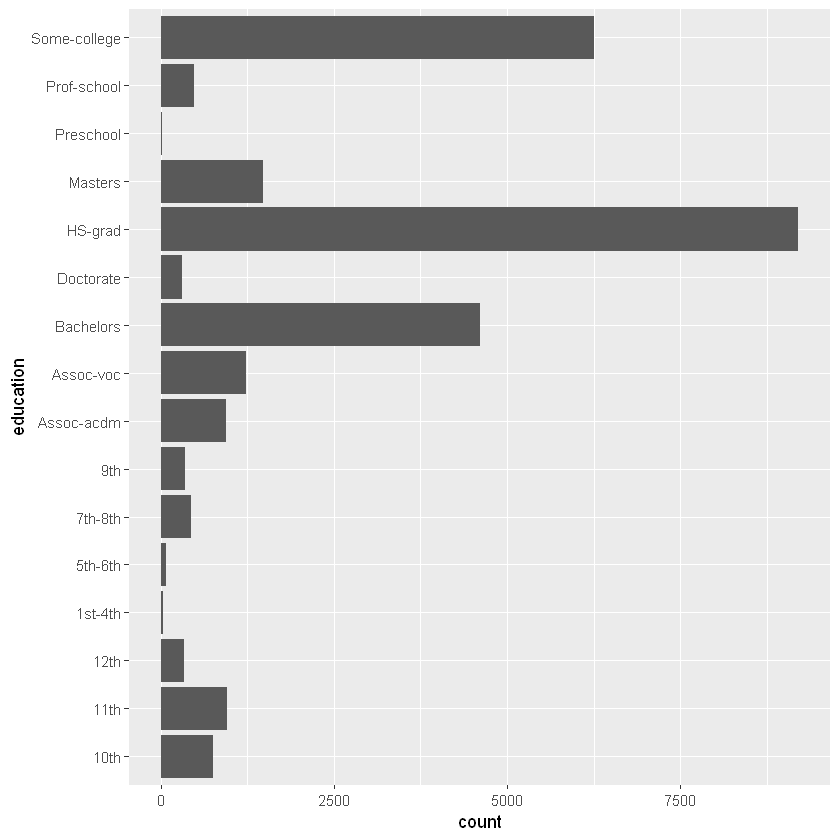

In [176]:
#data$education  <- as.factor(data$education )
#ggplot(data=data, aes(x=income))+geom_bar()
ggplot(data=data, aes(x=education ))+geom_bar() + coord_flip()

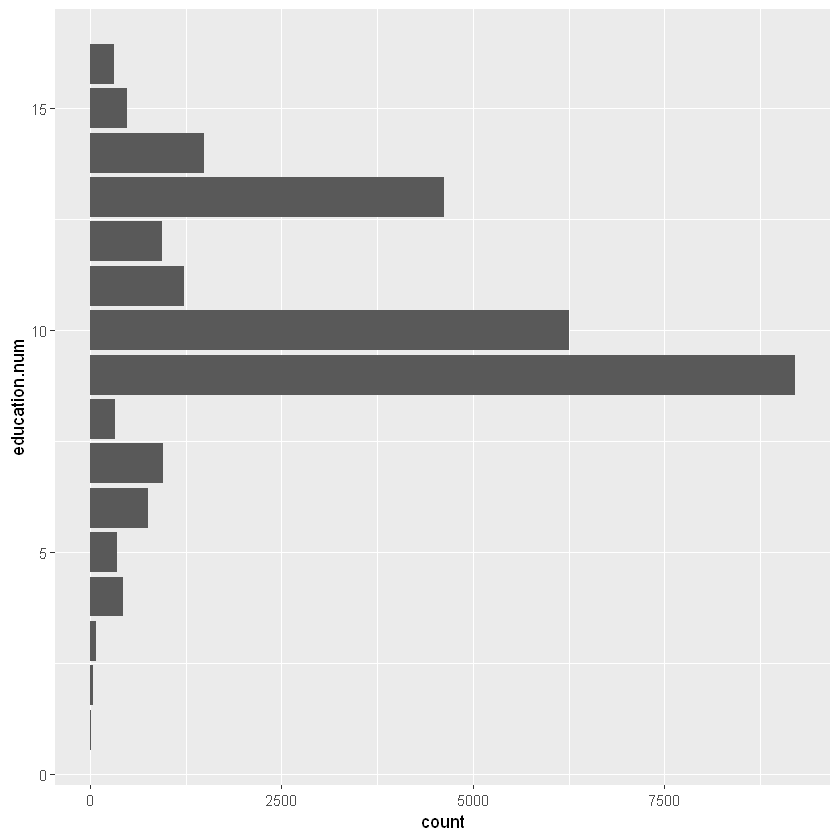

In [177]:
ggplot(data=data, aes(x=education.num ))+geom_bar() + coord_flip()

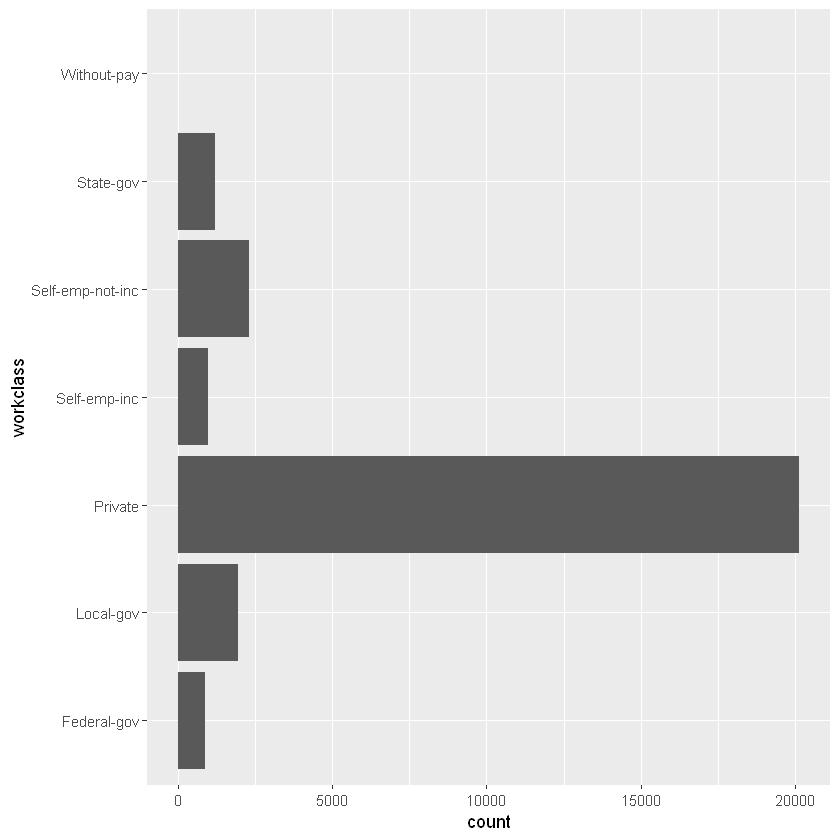

In [178]:
ggplot(data=data, aes(x=workclass      ))+geom_bar() + coord_flip()

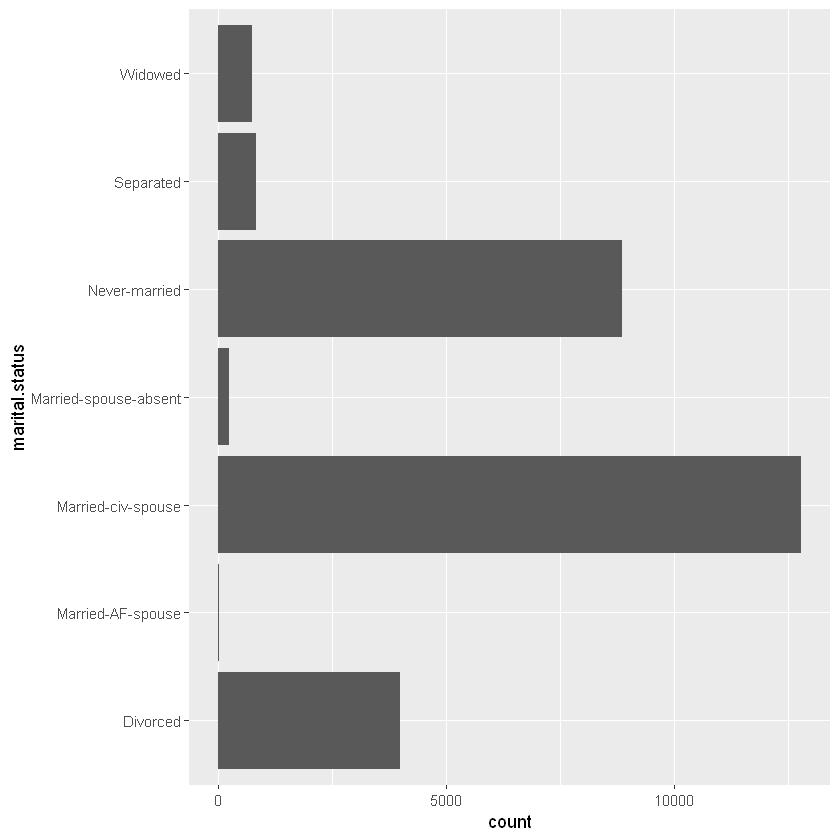

In [179]:
ggplot(data=data, aes(x=marital.status ))+geom_bar() + coord_flip()

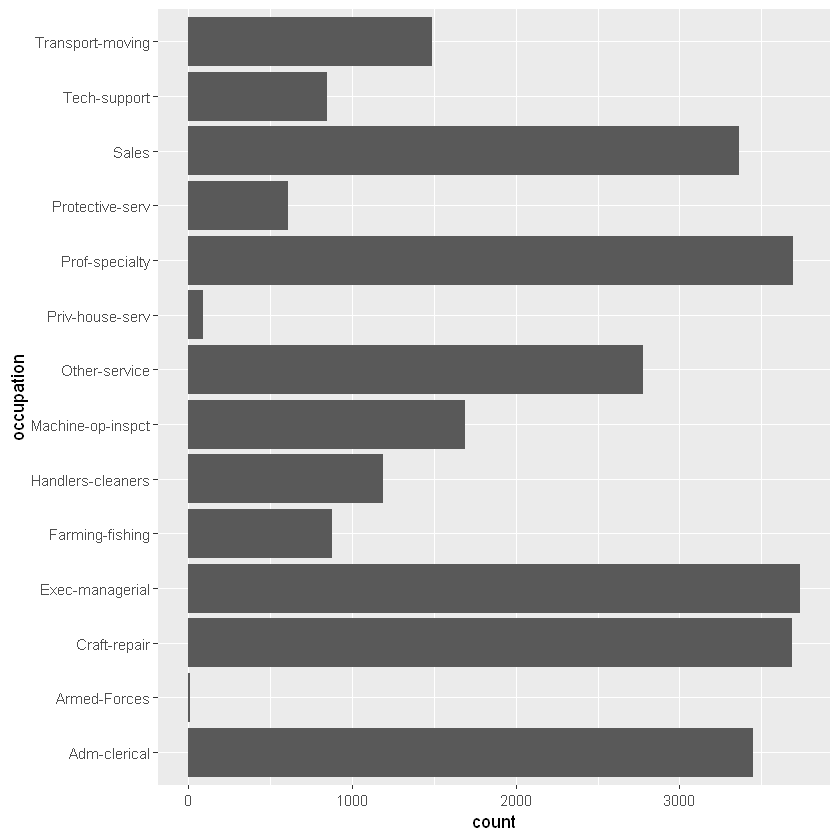

In [180]:
ggplot(data=data, aes(x=occupation     ))+geom_bar() + coord_flip()

In [181]:
#지금까지 봤던 charactor column을 factor로
data_dt <- data %>% mutate_if(is.character,as.factor)

In [107]:
str(data_dt)

'data.frame':	27504 obs. of  14 variables:
 $ age           : int  82 54 41 34 38 74 68 45 38 52 ...
 $ workclass     : Factor w/ 7 levels "Federal-gov",..: 3 3 3 3 3 6 1 3 5 3 ...
 $ fnlwgt        : int  132870 140359 264663 216864 150601 88638 422013 172274 164526 129177 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 12 6 16 12 1 11 12 11 15 10 ...
 $ education.num : int  9 4 10 9 6 16 9 16 15 13 ...
 $ marital.status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 7 1 6 1 6 5 1 1 5 7 ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: 4 7 10 8 1 10 10 10 10 8 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 2 5 4 5 5 3 2 5 2 2 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 5 5 5 5 5 3 5 5 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 1 1 1 1 2 1 1 1 2 1 ...
 $ capital.gain  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ capital.loss  : int  4356 3900 3900 3770 3770 3683 3683 3004 2824 2824 ...
 $ hours.per

In [182]:
# RANDOM SEED
set.seed(12345)

# 7:1.5:1.5으로 분할
# Simple into 3 sets.
idx <- sample(seq(1, 3), size = nrow(data), replace = TRUE, prob = c(.7, .15, .15))
train <- data_dt[idx == 1,]
test <- data_dt[idx == 2,]
val <- data_dt[idx == 3,]
# test와 validation의 역할 을 하는 dataset크기가 같으면 좋겠어서 위처럼 분배했습니다. 0.4 0.3.0.3 은 너무 
# train set크기가 작어서 .7, .15, .15 로 했고, 비슷한 의미로 0.8 0.1 0.1 은 test와 validation set크기가 너무 작아서 안했습니다.

# Performance table
Perf_Table <- matrix(0, nrow = 3, ncol =6)
rownames(Perf_Table) <- c("before Post-Pruning","Post-Pruning", "Pre-Pruning")
colnames(Perf_Table) <- c("TPR", "Precision", "TNR", "Accuracy", "BCR", "F1-Measure")
AUROC <- matrix(0,nrow=3,ncol=1)

# A2 - autistic data


Classification tree:
tree(formula = income ~ ., data = rbind(train, val))
Variables actually used in tree construction:
[1] "relationship" "capital.gain" "education"    "occupation"  
Number of terminal nodes:  8 
Residual mean deviance:  0.7177 = 16830 / 23450 
Misclassification error rate: 0.1597 = 3745 / 23455 

       CART_before_prune
        <=50K >50K
  <=50K  2843  153
  >50K    538  515

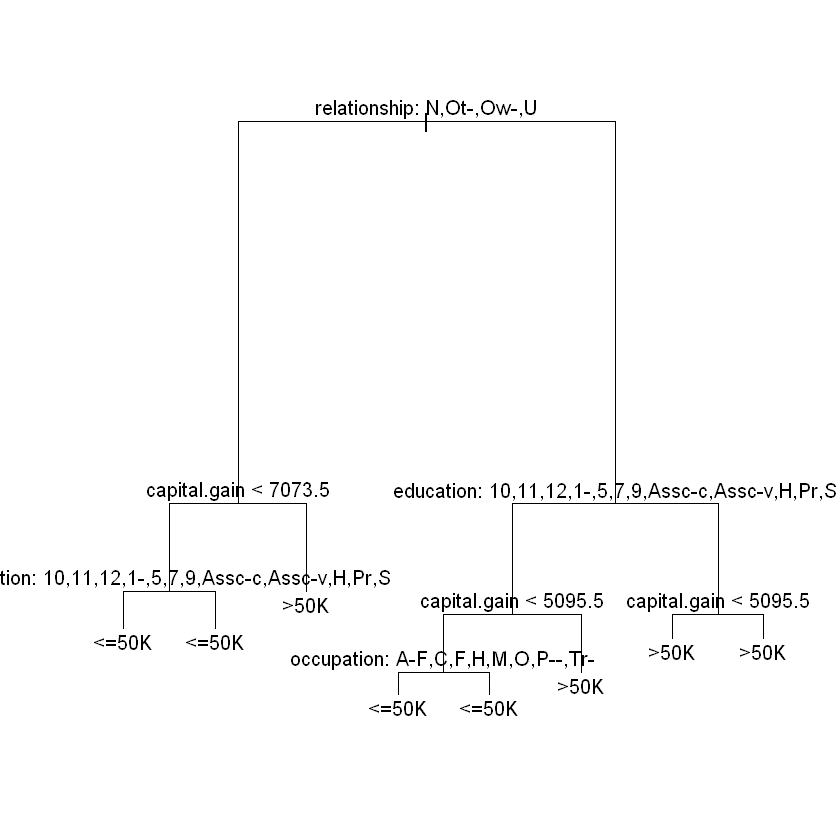

In [127]:
# Training the tree
CART_post <- tree(income ~ ., rbind(train,val))
summary(CART_post)

# Plot the tree
plot(CART_post)
text(CART_post, pretty = 1)

CART_before_prune<- predict(CART_post, newdata=test, type="class")
#CART_before_auroc<- predict(CART_post, newdata=test, type="vector")
CART_before_post_cm <- table(test$income, CART_before_prune)
CART_before_post_cm
Perf_Table[1,] <- perf_eval(CART_before_post_cm)

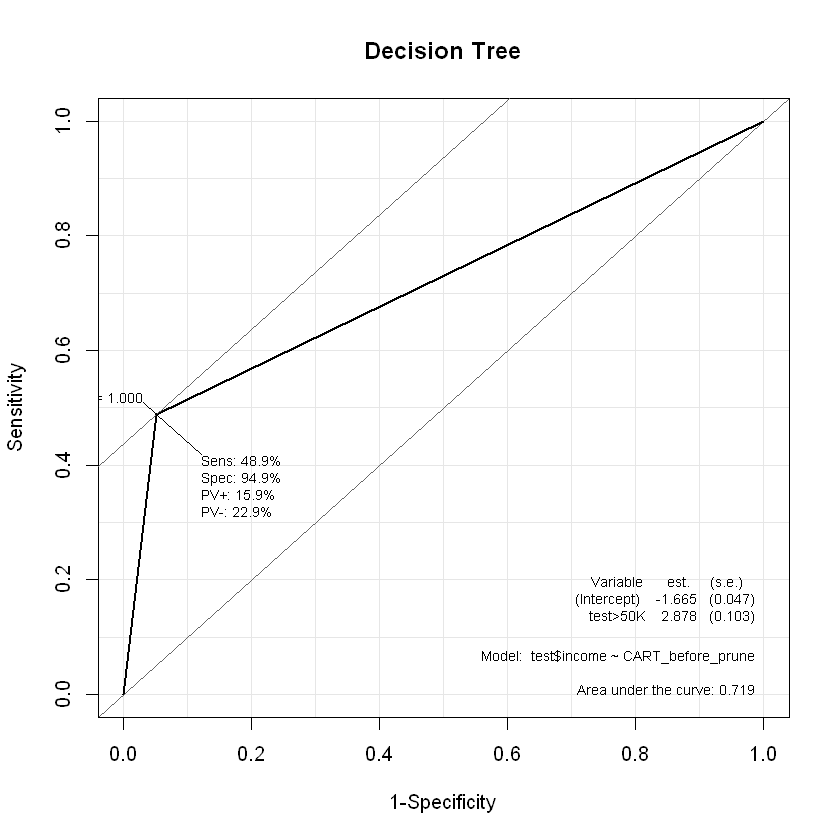

In [129]:
roc <- ROC(test=CART_before_prune, stat=test$income, plot="ROC", AUC=T, main="Decision Tree")
AUROC[1,]<-roc$AUC

In [54]:
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Pre-Pruning,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


accuracy자체는 좋지만, TPR가 너무 낮고, 50% 이하라는 점이 결점인 것 같습니다.
이러한 일이 일어난 이유는 false인 데이터가 너무 적어서 MISCLASSIFICATION ERROR RATE 자체는 그렇게 영향이 적은 것 같습니다. 
이를 다시 한다면 Class를 rebalancing 해서 해야될 것 같습니다.\

AUROC값은 0.719로 그리 좋지도 나쁘지도 않은 값 인 것 같습니다.

# A3- autistic : post-pruning

$size
[1] 8 5 4 3 1

$dev
[1] 3747 3747 3963 4339 5942

$k
[1]  -Inf   0.0 218.0 376.0 801.5

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

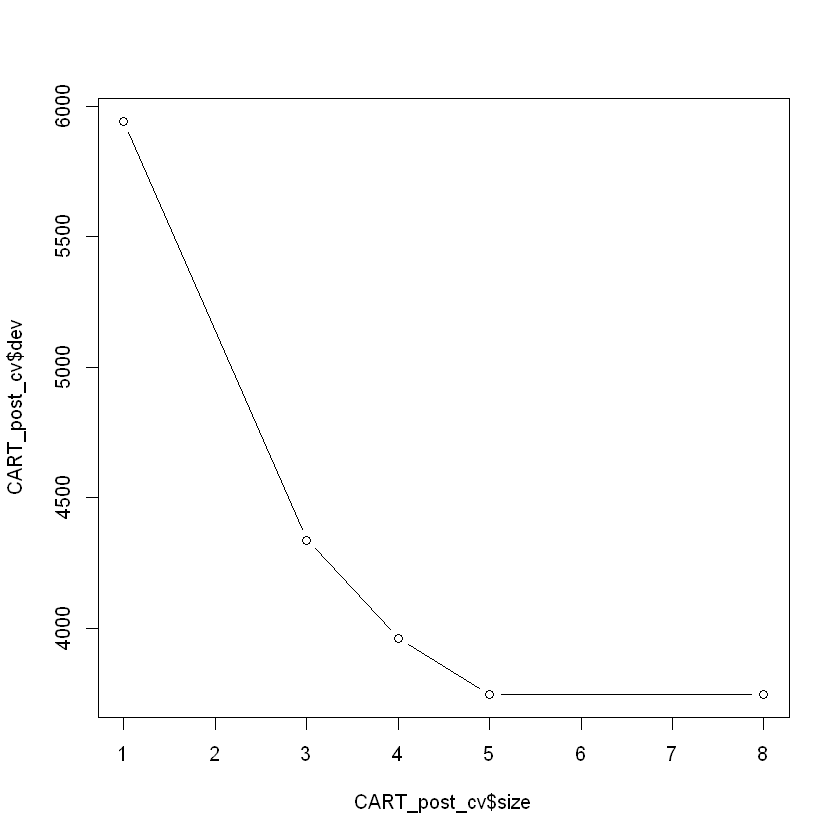

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 23455 26550.00 <=50K ( 0.74666 0.25334 )  
   2) relationship: Not-in-family,Other-relative,Own-child,Unmarried 12693  6529.00 <=50K ( 0.92862 0.07138 )  
     4) capital.gain < 7073.5 12459  5277.00 <=50K ( 0.94542 0.05458 ) *
     5) capital.gain > 7073.5 234    69.74 >50K ( 0.03419 0.96581 ) *
   3) relationship: Husband,Wife 10762 14880.00 <=50K ( 0.53206 0.46794 )  
     6) education: 10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,HS-grad,Preschool,Some-college 7547  9755.00 <=50K ( 0.65191 0.34809 )  
      12) capital.gain < 5095.5 7155  8899.00 <=50K ( 0.68651 0.31349 ) *
      13) capital.gain > 5095.5 392    78.10 >50K ( 0.02041 0.97959 ) *
     7) education: Bachelors,Doctorate,Masters,Prof-school 3215  3621.00 >50K ( 0.25070 0.74930 ) *

       CART_post_prey
        <=50K >50K
  <=50K  2843  153
  >50K    538  515

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Pre-Pruning,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


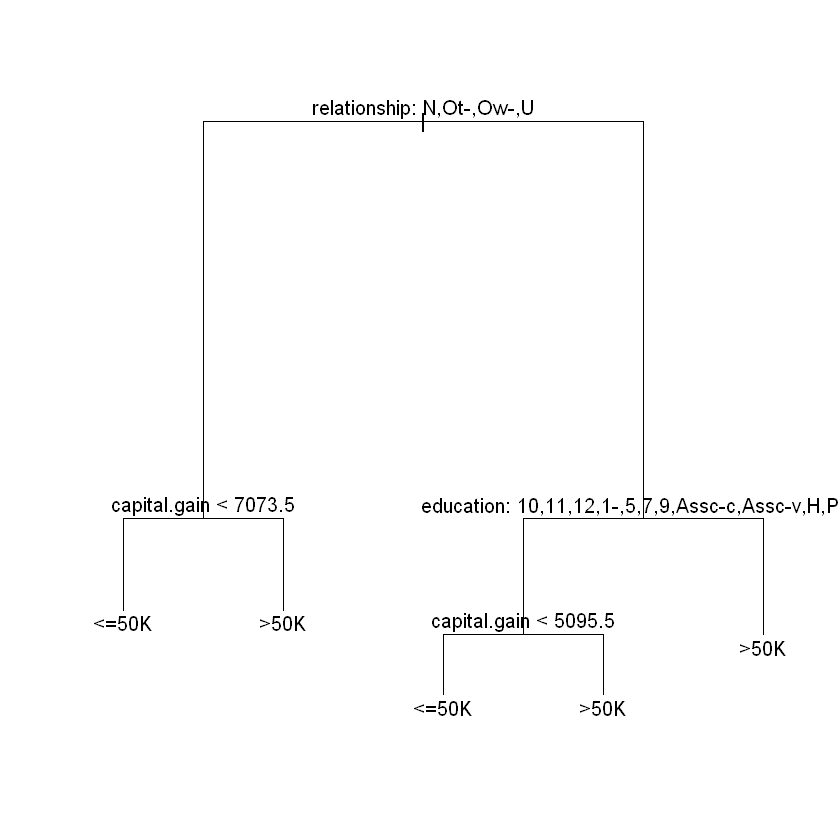

In [130]:
####################### tree 이용해 post pruning ####################
# Find the best tree
CART_post_cv <- cv.tree(CART_post, FUN = prune.misclass)

# Plot the pruning result
plot(CART_post_cv$size, CART_post_cv$dev, type = "b")
CART_post_cv

# Select the final model
CART_post_pruned <- prune.misclass(CART_post, best = 5)
plot(CART_post_pruned)
text(CART_post_pruned, pretty = 1)
CART_post_pruned

# Prediction 
CART_post_prey <- predict(CART_post_pruned, test, type = "class")

CART_post_cm <- table(test$income, CART_post_prey)
CART_post_cm

Perf_Table[2,] <- perf_eval(CART_post_cm)
Perf_Table

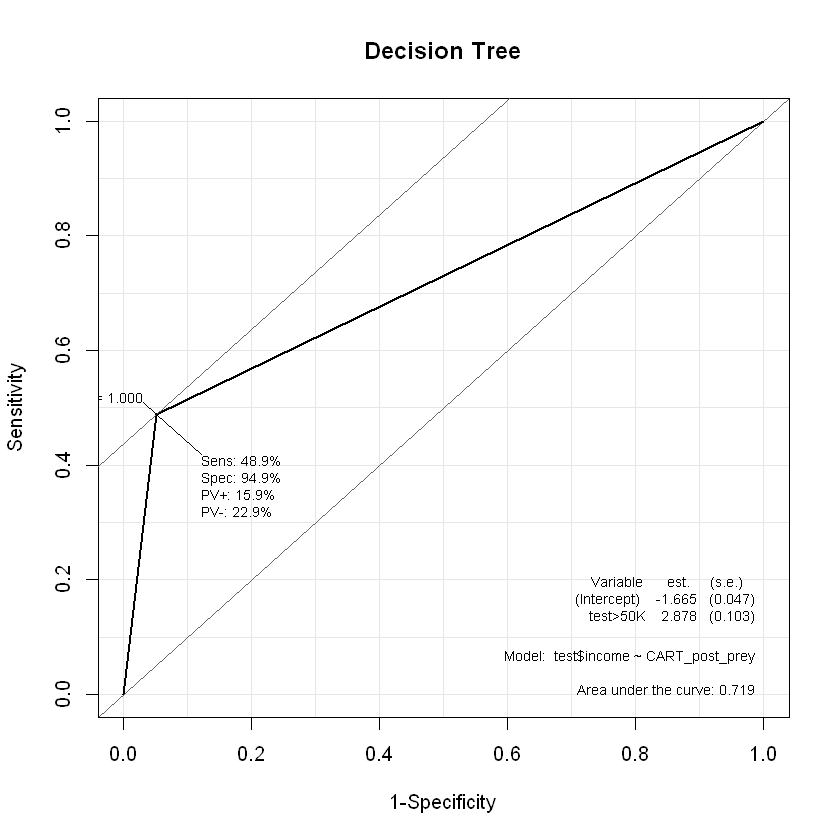

In [131]:
roc <- ROC(test=CART_post_prey, stat=test$income, plot="ROC", AUC=T, main="Decision Tree")
AUROC[2,]<-roc$AUC

In [55]:
Perf_Table

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Pre-Pruning,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


tree자체를 보면 pruning을 해서 모델이 변화했지만, 실제 performance measure값들의 변화가 없다.

split에 사용한 변수를 보면,
pruning을 하기 전에는 :"relationship" "capital.gain" "education"    "occupation"
pruning 한 후는 : "relationship" "capital.gain" "education"  

을 사용했다.

위 decision tree에서는 pruning을 하던 말던 둘다 education에 따라 income이 달라지는 것을 알 수 있다.
또한 pruning 전후 분류성능을 비교해보면 occupation은 영향이 없는 것을 알 수 있다.

또한 AUROC값 또한 변하지 않아 정말로 동일한 성능을 가졌구나를 다시한번 알 수 있다.

# A3- autistic : pre-pruning

In [50]:
a = c(0.7,0.75,0.8,0.85,0.9, 0.95, 0.99) #0.99를 제외하고 0.05의 등차수열을 사용했습니다
min_criterion = rev(a) # 동점이 많아 criterion이 높은 수치를 우선적으로 사용하려고 reverse order를 했습니다
min_split = c(1:15)
max_depth = c(0:7)
#  7 * 15 * 8 개의 조합을 실행해 보았다

CART_pre_search_result = matrix(0,length(min_criterion)*length(min_split)*length(max_depth),11)
colnames(CART_pre_search_result) <- c("min_criterion", "min_split", "max_depth", 
                           "TPR", "Precision", "TNR", "ACC", "BCR", "F1", "AUROC", "N_leaves")

iter_cnt = 1

for (i in 1:length(min_criterion)){
  for ( j in 1:length(min_split)){
    for ( k in 1:length(max_depth)){
      
      cat("CART Min criterion:", min_criterion[i], ", Min split:", min_split[j], ", Max depth:", max_depth[k], "\n")
      tmp_control = ctree_control(mincriterion = min_criterion[i], minsplit = min_split[j], maxdepth = max_depth[k])
      tmp_tree <- ctree(income ~ ., data = train, controls = tmp_control)
      tmp_tree_val_prediction <- predict(tmp_tree, newdata = val)
      tmp_tree_val_response <- treeresponse(tmp_tree, newdata = val) # 해당 클라스일 확률값 나타내줌
      tmp_tree_val_prob <- 1-unlist(tmp_tree_val_response, use.names=F)[seq(1,nrow(val)*2,2)] # for auroc
      tmp_tree_val_rocr <- prediction(tmp_tree_val_prob, val$income)
      # Confusion matrix for the validation dataset
      tmp_tree_val_cm <- table(val$income, tmp_tree_val_prediction)
      
      # parameters
      CART_pre_search_result[iter_cnt,1] = min_criterion[i]
      CART_pre_search_result[iter_cnt,2] = min_split[j]
      CART_pre_search_result[iter_cnt,3] = max_depth[k]
      # Performances from the confusion matrix
      CART_pre_search_result[iter_cnt,4:9] = perf_eval(tmp_tree_val_cm)
      # AUROC
      CART_pre_search_result[iter_cnt,10] = unlist(performance(tmp_tree_val_rocr, "auc")@y.values)
      # Number of leaf nodes
      CART_pre_search_result[iter_cnt,11] = length(nodes(tmp_tree, unique(where(tmp_tree))))
      iter_cnt = iter_cnt + 1
    }
  }
}

CART Min criterion: 0.99 , Min split: 1 , Max depth: 0 
CART Min criterion: 0.99 , Min split: 1 , Max depth: 1 
CART Min criterion: 0.99 , Min split: 1 , Max depth: 2 
CART Min criterion: 0.99 , Min split: 1 , Max depth: 3 
CART Min criterion: 0.99 , Min split: 1 , Max depth: 4 
CART Min criterion: 0.99 , Min split: 1 , Max depth: 5 
CART Min criterion: 0.99 , Min split: 1 , Max depth: 6 
CART Min criterion: 0.99 , Min split: 1 , Max depth: 7 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 0 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 1 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 2 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 3 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 4 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 5 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 6 
CART Min criterion: 0.99 , Min split: 2 , Max depth: 7 
CART Min criterion: 0.99 , Min split: 3 , Max depth: 0 
CART Min criterion: 0.99 , Min split: 3 , Max de

In [52]:
# Find the best set of parameters
CART_pre_search_result <- CART_pre_search_result[order(CART_pre_search_result[,10], decreasing = T),]
CART_pre_search_result
best_criterion <- CART_pre_search_result[1,1]
best_split <- CART_pre_search_result[1,2]
best_depth <- CART_pre_search_result[1,3]

# Construct the best tree
tree_control = ctree_control(mincriterion = best_criterion, minsplit = best_split, maxdepth = best_depth)

cat("best_criterion:",best_criterion,"\nbest_split:",best_split,"\nbest_depth:",best_depth)


min_criterion,min_split,max_depth,TPR,Precision,TNR,ACC,BCR,F1,AUROC,N_leaves
0.80,1,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,2,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,3,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,4,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,5,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,6,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,7,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,8,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,9,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87
0.80,10,0,0.6242884,0.9372549,0.7741176,0.8570734,0.7649297,0.6911765,0.9087756,87


best_criterion: 0.8 
best_split: 1 
best_depth: 0

위 파라미터중 최적의 파리미터는 아래와 같다.

best_criterion: 0.8 
best_split: 1 
best_depth: 0

# A4 : 최적의 decision tree plot


	 Conditional inference tree with 15 terminal nodes

Response:  income 
Inputs:  age, workclass, fnlwgt, education, education.num, marital.status, occupation, relationship, race, sex, capital.gain, capital.loss, hours.per.week 
Number of observations:  23455 

1) relationship == {Not-in-family, Other-relative, Own-child, Unmarried}; criterion = 1, statistic = 4964.135
  2) education == {10th, 11th, 12th, 1st-4th, 5th-6th, 7th-8th, 9th, Assoc-acdm, Assoc-voc, Bachelors, HS-grad, Preschool, Some-college}; criterion = 1, statistic = 1327.485
    3) capital.gain <= 7978; criterion = 1, statistic = 1066.823
      4) occupation == {Adm-clerical, Armed-Forces, Farming-fishing, Handlers-cleaners, Machine-op-inspct, Other-service, Priv-house-serv}; criterion = 1, statistic = 392.512
        5)*  weights = 5873 
      4) occupation == {Craft-repair, Exec-managerial, Prof-specialty, Protective-serv, Sales, Tech-support, Transport-moving}
        6)*  weights = 5921 
    3) capital.gain > 7978
  

png 
  3

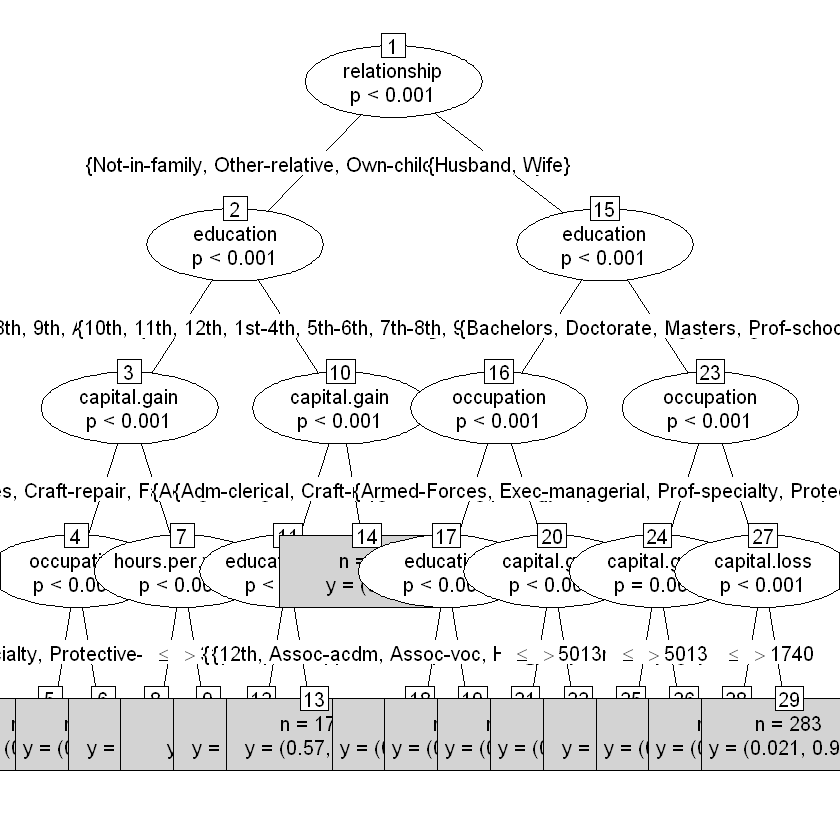

In [145]:
# Use the training and validation dataset to train the best tree
CART_trn <- rbind(train, val)
CART_pre <- ctree(income ~ ., data = CART_trn, controls = tree_control)
CART_pre
# Plot the best tree
plot(CART_pre, type="simple")
dev.off()

png("CART_pre3.png", res=80, height=800, width=1600) 


위 최적 의사결정나무에서 알 수 있는 사실은 
1. education은 대부분 Doctorate, Masters vs others 로 나눠지고, 
2. relation에서 husband & wife vs others 느낌인데, 부부관계와 아닌것으로 나눠진 점이 흥미로운 것 같다
3. capital gain 이 많을 수록 income이 많은 것은 거의 선형 관계 인 것 같다

# A5

In [146]:

CART_pre_prediction <- predict(CART_pre, newdata = test)
CART_pre_response <- treeresponse(CART_pre, newdata = test)

# Performance of the best tree
CART_pre_cm <- table(test$income, CART_pre_prediction)
CART_pre_cm

Perf_Table[3,] <- perf_eval(CART_pre_cm)


       CART_pre_prediction
        <=50K >50K
  <=50K  2884  112
  >50K    614  439

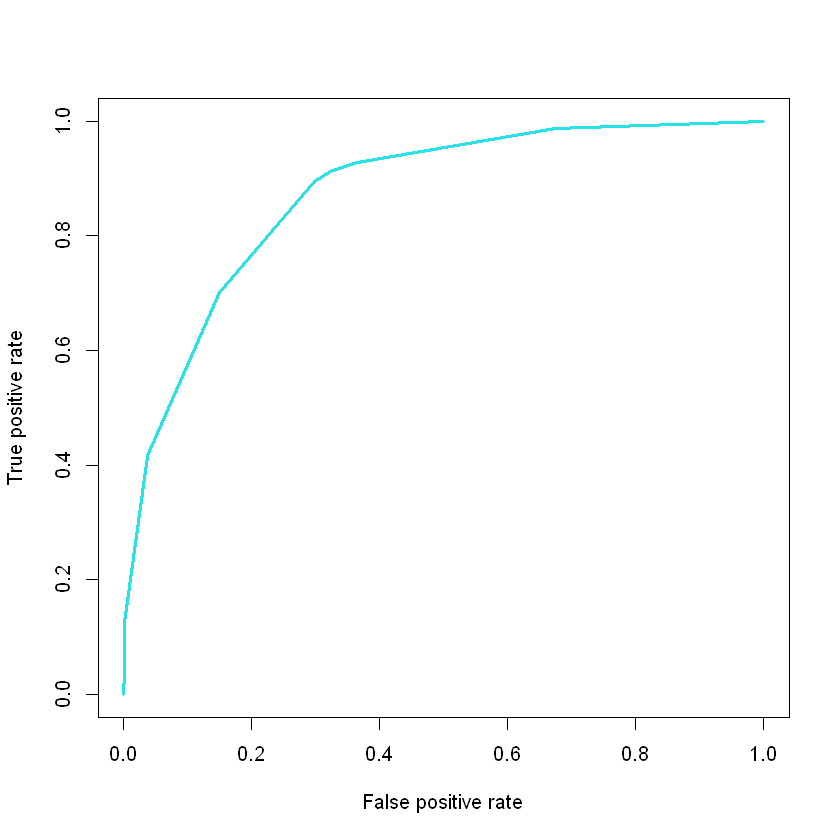

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Post-Pruning,0.4890788,0.9489319,0.7709581,0.8293406,0.6812507,0.5984893
Pre-Pruning,0.4169041,0.9626168,0.7967332,0.8206965,0.6334973,0.5473815


0.7190054
0.7190054
0.6897605


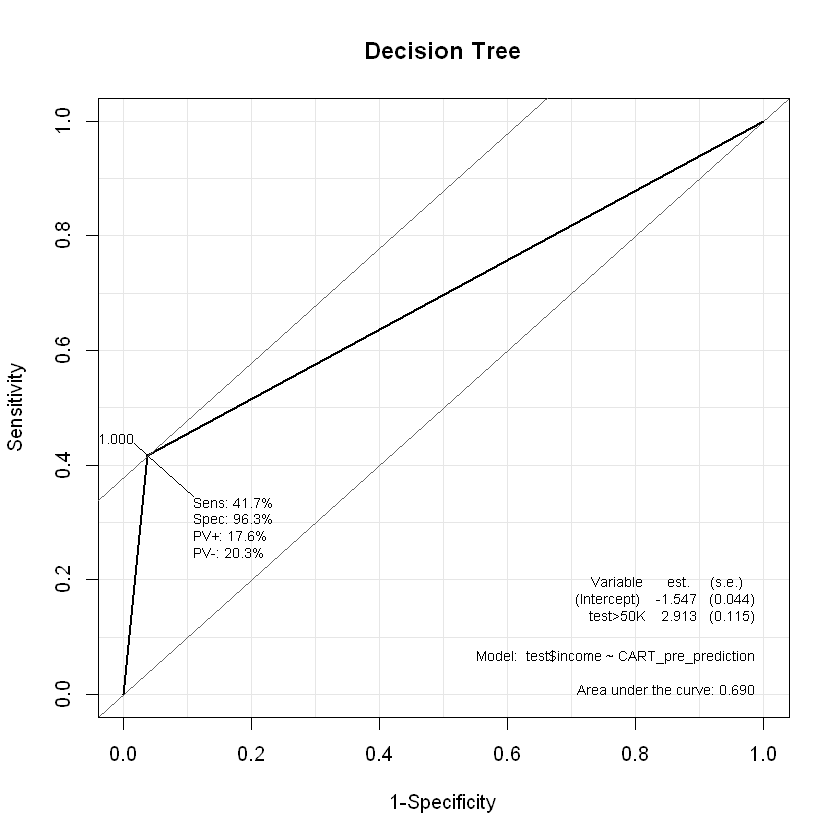

In [149]:
# Plot the ROC
CART_pre_prob <- 1-unlist(CART_pre_response, use.names=F)[seq(1,nrow(test)*2,2)]
CART_pre_rocr <- prediction(CART_pre_prob, test$income)
CART_pre_perf <- performance(CART_pre_rocr, "tpr","fpr") 
plot(CART_pre_perf, col=5, lwd = 3)

roc <- ROC(test=CART_pre_prediction, stat=test$income, plot="ROC", AUC=T, main="Decision Tree")
AUROC[3,]<-roc$AUC
Perf_Table
AUROC

위 모델의  performance measure를 봤을 때 pre-pruning model은 위의 두 모델보다 성능이 TNR을 제외한 모든 지표에서 더 안좋다.
즉 위 모델에서 가장 좋은 성능을 가진건 before post pruning model임으로 그 값을 perf_table_total에 넣어준다


In [150]:
Perf_Table_total[2,] <- Perf_Table[3,] 

# A6: logistic regression

위 데이터에 존재하는 다양한 character type 변수들은 나중에 할 logistic regression을 위해 one-hot 인코딩으로 변환한다

In [183]:
data_char <- data %>% keep(is.character)
data_not_char <-data[, !(names(data)) %in% colnames(data_char)]
data_char<-data_char %>% mutate_if(is.character,as.factor)

#data_fac2 : character to numeric
dummy1 <- class.ind(data_char[,1])[,-1]
colnames(dummy1) <- paste(rep(colnames(data_char)[1],ncol(dummy1)),colnames(dummy1),sep='_')

dummy2 <- class.ind(data_char[,2])[,-1]
colnames(dummy2) <- paste(rep(colnames(data_char)[2],ncol(dummy2)),colnames(dummy2),sep='_')

dummy3 <- class.ind(data_char[,3])[,-1]
colnames(dummy3) <- paste(rep(colnames(data_char)[3],ncol(dummy3)),colnames(dummy3),sep='_')

dummy4 <- class.ind(data_char[,4])[,-1]
colnames(dummy4) <- paste(rep(colnames(data_char)[4],ncol(dummy4)),colnames(dummy4),sep='_')

dummy5 <- class.ind(data_char[,5])[,-1]
colnames(dummy5) <- paste(rep(colnames(data_char)[5],ncol(dummy5)),colnames(dummy5),sep='_')

dummy6 <- class.ind(data_char[,6])[,-1]
colnames(dummy6) <- paste(rep(colnames(data_char)[6],ncol(dummy6)),colnames(dummy6),sep='_')

dummys <- cbind(dummy1, dummy2, dummy3, dummy4, dummy5, dummy6)

df<-cbind(data_not_char,dummys,data_char[,7],data_char[,8])
colnames(df)[56:57] <- c("sex","income")

colnames(df) <- sub('-', '_', colnames(df))
summary(df)

df<- df %>% mutate_if(is.character,as.factor)


# RANDOM SEED
set.seed(12345)

# 7:1.5:1.5으로 분할
# Simple into 3 sets.
idx <- sample(seq(1, 3), size = nrow(data), replace = TRUE, prob = c(.7, .15, .15))
train <- df[idx == 1,]
test <- df[idx == 2,]
val <- df[idx == 3,]
# test와 validation의 역할 을 하는 dataset크기가 같으면 좋겠어서 위처럼 분배했습니다. 0.4 0.3.0.3 은 너무 
# train set크기가 작어서 .7, .15, .15 로 했고, 비슷한 의미로 0.8 0.1 0.1 은 test와 validation set크기가 너무 작아서 안했습니다.


      age           fnlwgt        education.num    capital.gain  
 Min.   :17.0   Min.   :  13769   Min.   : 1.00   Min.   :    0  
 1st Qu.:28.0   1st Qu.: 115856   1st Qu.: 9.00   1st Qu.:    0  
 Median :37.0   Median : 176811   Median :10.00   Median :    0  
 Mean   :38.5   Mean   : 187055   Mean   :10.22   Mean   : 1120  
 3rd Qu.:47.0   3rd Qu.: 234108   3rd Qu.:13.00   3rd Qu.:    0  
 Max.   :90.0   Max.   :1484705   Max.   :16.00   Max.   :99999  
  capital.loss     hours.per.week  workclass_Local_gov workclass_Private
 Min.   :   0.00   Min.   : 1.00   Min.   :0.00000     Min.   :0.0000   
 1st Qu.:   0.00   1st Qu.:40.00   1st Qu.:0.00000     1st Qu.:0.0000   
 Median :   0.00   Median :40.00   Median :0.00000     Median :1.0000   
 Mean   :  90.27   Mean   :40.97   Mean   :0.07112     Mean   :0.7321   
 3rd Qu.:   0.00   3rd Qu.:45.00   3rd Qu.:0.00000     3rd Qu.:1.0000   
 Max.   :4356.00   Max.   :99.00   Max.   :1.00000     Max.   :1.0000   
 workclass_Self_emp-inc wor

In [184]:
lr <- glm(income ~., train, family = "binomial")
summary(lr)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = income ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2108  -0.5286  -0.1868   0.0000   3.3804  

Coefficients: (1 not defined because of singularities)
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                            -9.472e+00  7.085e-01 -13.369  < 2e-16
age                                     2.799e-02  2.141e-03  13.071  < 2e-16
fnlwgt                                  6.620e-07  2.164e-07   3.059 0.002222
education.num                           2.701e-01  4.958e-02   5.448 5.10e-08
capital.gain                            3.327e-04  1.345e-05  24.732  < 2e-16
capital.loss                            6.406e-04  4.851e-05  13.206  < 2e-16
hours.per.week                          2.920e-02  2.110e-03  13.842  < 2e-16
workclass_Local_gov                    -7.122e-01  1.393e-01  -5.111 3.20e-07
workclass_Private                      -4.116e-01  1.155e-01

In [185]:
lr$coefficient

(Intercept)                                    age 
                         -9.472179e+00                           2.798584e-02 
                                fnlwgt                          education.num 
                          6.619505e-07                           2.701060e-01 
                          capital.gain                           capital.loss 
                          3.326954e-04                           6.405807e-04 
                        hours.per.week                    workclass_Local_gov 
                          2.920270e-02                          -7.122170e-01 
                     workclass_Private               `workclass_Self_emp-inc` 
                         -4.116284e-01                          -2.869302e-01 
          `workclass_Self_emp-not-inc`                    workclass_State_gov 
                         -9.058674e-01                          -6.796293e-01 
                 workclass_Without_pay                         education_11th 
                         -1.423772e+01                          -2.080912e-01 
                        education_12th                      education_1st_4th 
                          5.211095e-02                          -1.164971e+01 
                     education_5th_6th                      education_7th_8th 
                         -1.198068e-01                          -2.082790e-01 
                         education_9th                   education_Assoc_acdm 
                          2.026245e-01                          -2.892332e-01 
                   education_Assoc_voc                    education_Bachelors 
                         -1.000173e-01                           1.064045e-01 
                   education_Doctorate                      education_HS_grad 
                          3.788571e-01                          -7.136934e-03 
                     education_Masters                    education_Preschool 
                          1.813962e-01                          -9.381307e+00 
                 education_Prof_school                 education_Some_college 
                          3.826253e-01                                     NA 
    `marital.status_Married_AF-spouse`    `marital.status_Married_civ-spouse` 
                          2.195455e+00                           2.340002e+00 
`marital.status_Married_spouse-absent`           marital.status_Never_married 
                          1.237038e-01                          -5.059717e-01 
              marital.status_Separated                 marital.status_Widowed 
                         -1.713265e-01                           7.951509e-02 
               occupation_Armed_Forces                occupation_Craft_repair 
                         -2.582626e-01                           1.492537e-01 
            occupation_Exec_managerial             occupation_Farming_fishing 
                          8.401671e-01                          -9.600362e-01 
          occupation_Handlers_cleaners         `occupation_Machine_op-inspct` 
                         -6.974987e-01                          -1.532857e-01 
              occupation_Other_service           `occupation_Priv_house-serv` 
                         -8.504532e-01                          -1.220276e+01 
             occupation_Prof_specialty             occupation_Protective_serv 
                          5.613172e-01                           7.279916e-01 
                      occupation_Sales                occupation_Tech_support 
                          3.477374e-01                           8.078603e-01 
           occupation_Transport_moving           `relationship_Not_in-family` 
                         -7.266425e-04                           7.068871e-01 
           relationship_Other_relative                 relationship_Own_child 
                         -3.317604e-01                          -6.321533e-01 
                relationship_Unmarried                      relationship_Wife

In [153]:
tst <-rbind(val,test)
lr_response <- predict(lr, type = "response", newdata = tst)
lr_target <-tst$income
lr_predicted <- rep(0, length(lr_target))
lr_predicted[which(lr_response >= 0.5)] <- 1
cm_full <- table(lr_target, lr_predicted)
cm_full

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


         lr_predicted
lr_target    0    1
    <=50K 5594  462
    >50K   820 1287

In [154]:
Perf_Table_total[1,]<-perf_eval(cm_full)

In [155]:
Perf_Table_total

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
D1_LR,0.6108211,0.9237120,0.7358491,0.8429499,0.7511476,0.6675311
D1_Decision Tree,0.4169041,0.9626168,0.7967332,0.8206965,0.6334973,0.5473815
D2_LR,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
D2_Decision Tree,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


위모델에 대한 해석은 아래에서 쓸 것 이다

# ----------------------------------------------------------------------------------------------------------
# Diabetes

In [187]:
# Performance table
Perf_Table <- matrix(0, nrow = 3, ncol =6)
rownames(Perf_Table) <- c("before Post-Pruning","Post-Pruning", "Pre-Pruning")
colnames(Perf_Table) <- c("TPR", "Precision", "TNR", "Accuracy", "BCR", "F1-Measure")
Perf_Table

data<- read.csv("C:/Users/user/Desktop/고려대학교 4학년/다변량 분석/실습/assignment2/diabetes2.csv")
str(data)
data$Outcome <- as.factor(data$Outcome) # 설명변수가 숫자 -> factor

# RANDOM SEED
set.seed(12345)

# 6: 2:2으로 분할
# Simple into 3 sets.
idx <- sample(seq(1, 3), size = nrow(data), replace = TRUE, prob = c(.7, .15, .15))
train <- data[idx == 1,]
test <- data[idx == 2,]
val <- data[idx == 3,]
# test와 validation의 역할 을 하는 dataset크기가 같으면 좋겠어서 위처럼 분배했습니다. 0.4 0.3.0.3 은 너무 
# train set크기가 작어서 .7, .15, .15 로 했고, 비슷한 의미로 0.8 0.1 0.1 은 test와 validation set크기가 너무 작아서 안했습니다.



,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0,0,0,0,0,0
Post-Pruning,0,0,0,0,0,0
Pre-Pruning,0,0,0,0,0,0


'data.frame':	768 obs. of  9 variables:
 $ Pregnancies             : int  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose                 : int  148 85 183 89 137 116 78 115 197 125 ...
 $ BloodPressure           : int  72 66 64 66 40 74 50 0 70 96 ...
 $ SkinThickness           : int  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin                 : int  0 0 0 94 168 0 88 0 543 0 ...
 $ BMI                     : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ DiabetesPedigreeFunction: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age                     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ Outcome                 : int  1 0 1 0 1 0 1 0 1 1 ...


# A2 - diabetes

사용되는 변수: glucose, bmi, age, insulin --> 8개의 독립변수들 중 4개만 사용된다는 것을 알 수 있다.

1. glucose < 127.5 --> bmi > 26.45 --> age > 28.5 --> glucose >103.5 : 1
2. glucose > 127.5 --> bmi < 28.85 --> 27< age < 56 : 1
3. glucose > 127.5 --> bmi > 28.85 --> 1 except age < 34.5


 이 데이터 역시 위 데이터와 마찬가지로, false alarm보다 missed alarm이 더 cost가 큼으로, TPR를 중점으로 모델을 평가해야 된다. 그렇기에 상대적으로 Accuracy와 tpr의 차이가 크지 않은 것을 보아 그리 나쁘지 않지만, 그래도 TNR값이 거의 0.5에 가깝기에 그렇게 우수한 모델은 아닌 것 같다


Classification tree:
tree(formula = Outcome ~ ., data = rbind(train, val))
Variables actually used in tree construction:
[1] "Glucose" "BMI"     "Age"     "Insulin"
Number of terminal nodes:  12 
Residual mean deviance:  0.8365 = 530.4 / 634 
Misclassification error rate: 0.1966 = 127 / 646 

   CART_before_prune
     0  1
  0 61 23
  1 10 28

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0.7368421,0.7261905,0.5490196,0.7295082,0.7314969,0.6292135
Post-Pruning,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
Pre-Pruning,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


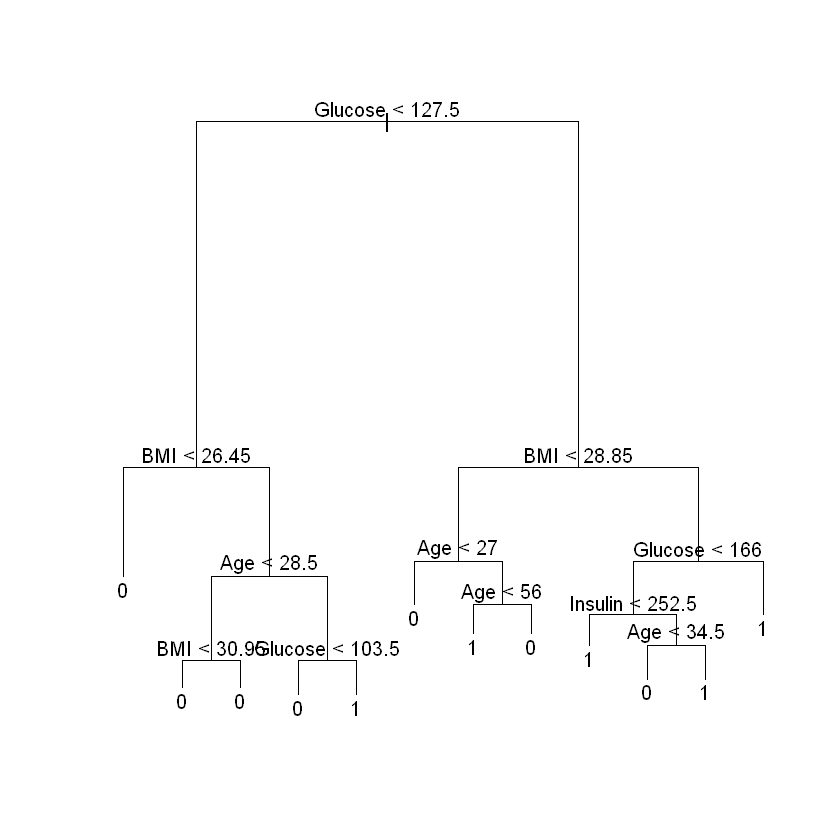

0.7315163
0.0000000
0.0000000


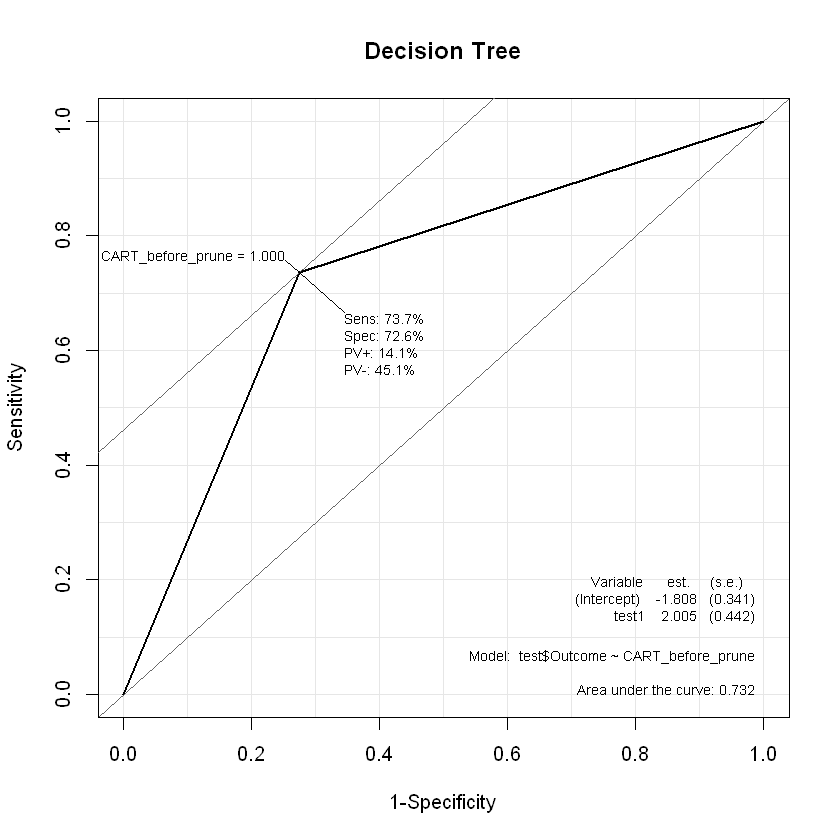

In [192]:
###################################before tree ###############################
# Training the tree
CART_post <- tree(Outcome ~ ., rbind(train,val))
summary(CART_post)

# Plot the tree
plot(CART_post,)
text(CART_post, pretty = 1)

CART_before_prune<- predict(CART_post, newdata=test, type="class")
CART_before_post_cm <- table(test$Outcome, CART_before_prune)
CART_before_post_cm
Perf_Table[1,] <- perf_eval(CART_before_post_cm)
Perf_Table

AUROC <- matrix(0,nrow=3,ncol=1)
roc <- ROC(test=CART_before_prune, stat=test$Outcome, plot="ROC", AUC=T, main="Decision Tree")
AUROC[1,]<-roc$AUC
AUROC

# A3-diabetes : post pruning


아래 모델은 glucose --> bmi 를 가지고 종속변수를 판별한다.
deviance가 3에서 가장 적기 때문에 3을 node 수로 정했다.

- 위 모델과 공통적으로 사용되는 변수: glucose, bmi
- before pruning만 사용하는 변수: age, insulin


위 문제에서 언급한것 처럼 이 모델의 목적은 tpr을 높이는 것이기 때문에, precision, TNR이 위 모델 보다 좋아져도, tpr가 더 낮기 때문에 위 모델이 더 좋다.

$size
[1] 12 11  8  6  3  2  1

$dev
[1] 173 173 176 179 176 192 222

$k
[1] -Inf  0.0  1.0  2.5  4.0 23.0 60.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

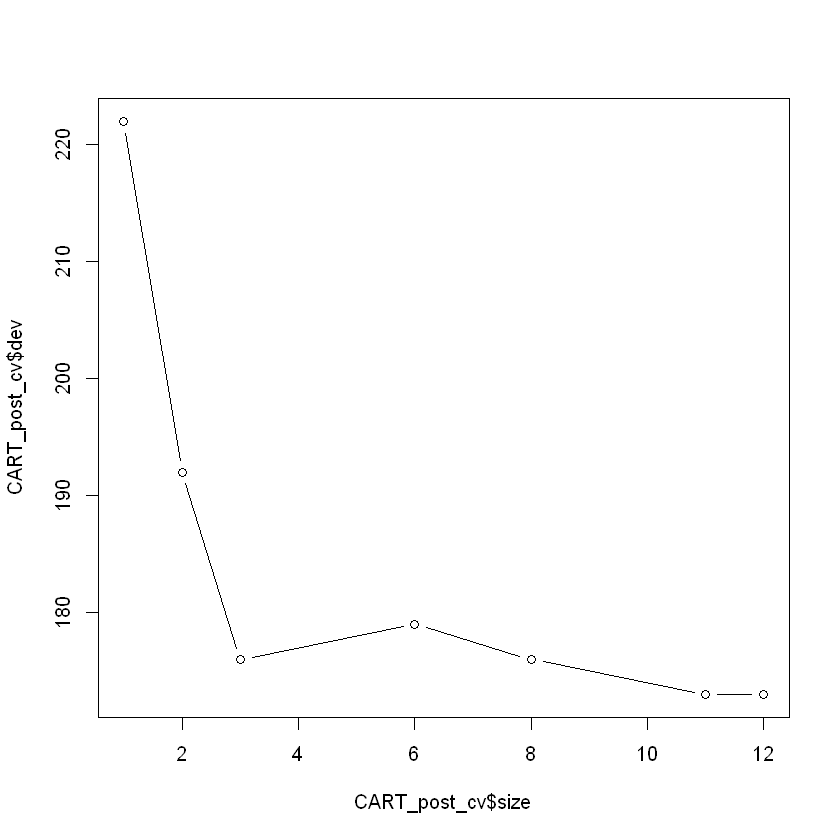

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

1) root 646 841.20 0 ( 0.6440 0.3560 )  
  2) Glucose < 127.5 404 399.30 0 ( 0.8045 0.1955 ) *
  3) Glucose > 127.5 242 320.50 1 ( 0.3760 0.6240 )  
    6) BMI < 28.85 53  63.15 0 ( 0.7170 0.2830 ) *
    7) BMI > 28.85 189 224.30 1 ( 0.2804 0.7196 ) *

   CART_post_prey
     0  1
  0 72 12
  1 19 19

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0.7368421,0.7261905,0.5490196,0.7295082,0.7314969,0.6292135
Post-Pruning,0.5000000,0.8571429,0.6129032,0.7459016,0.6546537,0.5507246
Pre-Pruning,0.5789474,0.8214286,0.5945946,0.7459016,0.6896114,0.5866667


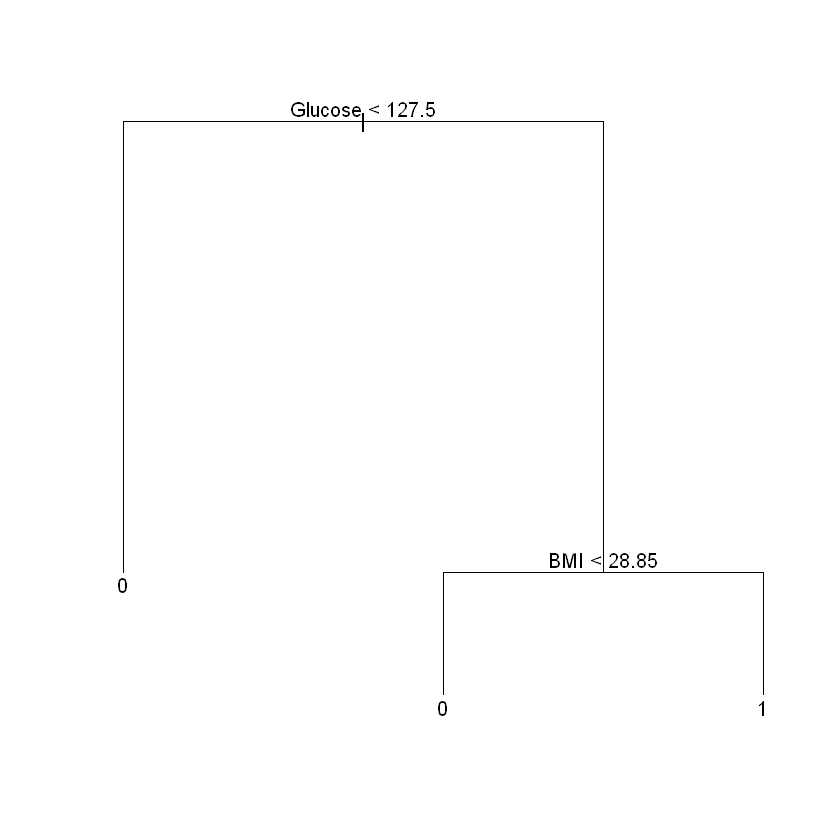

0.7315163
0.6785714
0.0000000


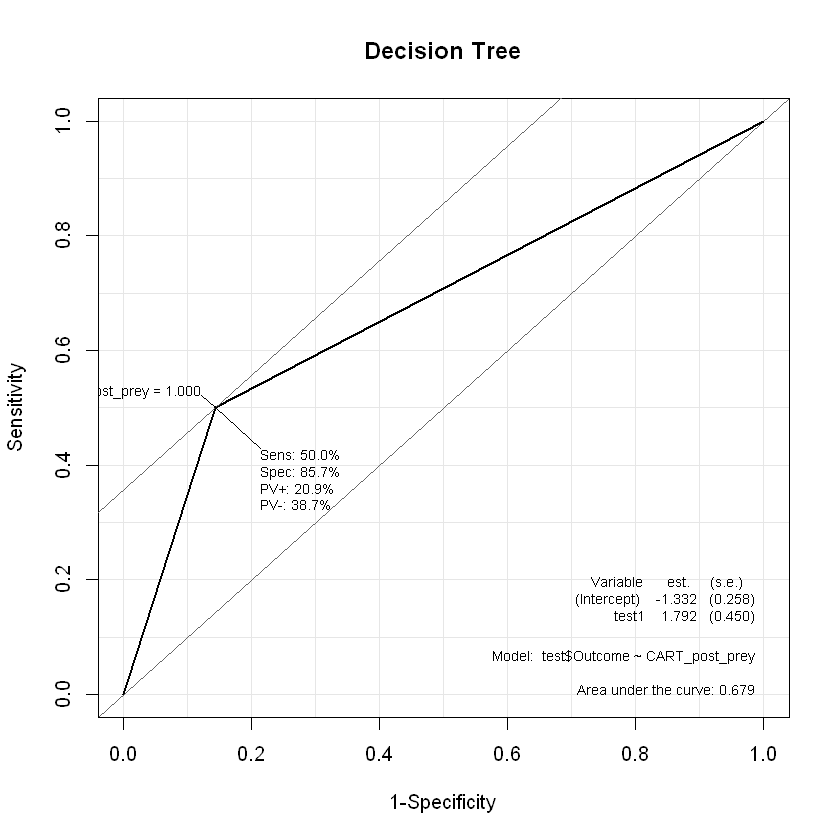

In [196]:

############################# tree 이용해 post pruning ####################
# Find the best tree
CART_post_cv <- cv.tree(CART_post, FUN = prune.misclass)

# Plot the pruning result
plot(CART_post_cv$size, CART_post_cv$dev, type = "b")
CART_post_cv

# Select the final model
CART_post_pruned <- prune.misclass(CART_post, best = 3)
plot(CART_post_pruned)
text(CART_post_pruned, pretty = 1)
CART_post_pruned

# Prediction 
CART_post_prey <- predict(CART_post_pruned, test, type = "class")

CART_post_cm <- table(test$Outcome, CART_post_prey)
CART_post_cm

Perf_Table[2,] <- perf_eval(CART_post_cm)
Perf_Table

roc <- ROC(test=CART_post_prey, stat=test$Outcome, plot="ROC", AUC=T, main="Decision Tree")
AUROC[2,]<-roc$AUC
AUROC

# A3-diabetes: pre pruning

In [159]:
min_criterion = c(0.7,0.75,0.8,0.85,0.9, 0.95, 0.99)
min_split = c(1,2,3,4,5,6,7,8,9,10,15, 20)
max_depth = c(0, 1,2,3,4,5)
CART_pre_search_result = matrix(0,length(min_criterion)*length(min_split)*length(max_depth),11)
colnames(CART_pre_search_result) <- c("min_criterion", "min_split", "max_depth", 
                           "TPR", "Precision", "TNR", "ACC", "BCR", "F1", "AUROC", "N_leaves")

iter_cnt = 1

for (i in 1:length(min_criterion)){
  for ( j in 1:length(min_split)){
    for ( k in 1:length(max_depth)){
      
      cat("CART Min criterion:", min_criterion[i], ", Min split:", min_split[j], ", Max depth:", max_depth[k], "\n")
      tmp_control = ctree_control(mincriterion = min_criterion[i], minsplit = min_split[j], maxdepth = max_depth[k])
      tmp_tree <- ctree(Outcome ~ ., data = train, controls = tmp_control)
      tmp_tree_val_prediction <- predict(tmp_tree, newdata = val)
      tmp_tree_val_response <- treeresponse(tmp_tree, newdata = val) # 해당 클라스일 확률값 나타내줌
      tmp_tree_val_prob <- 1-unlist(tmp_tree_val_response, use.names=F)[seq(1,nrow(val)*2,2)] # for auroc
      tmp_tree_val_rocr <- prediction(tmp_tree_val_prob, val$Outcome)
      # Confusion matrix for the validation dataset
      tmp_tree_val_cm <- table(val$Outcome, tmp_tree_val_prediction)
      
      # parameters
      CART_pre_search_result[iter_cnt,1] = min_criterion[i]
      CART_pre_search_result[iter_cnt,2] = min_split[j]
      CART_pre_search_result[iter_cnt,3] = max_depth[k]
      # Performances from the confusion matrix
      CART_pre_search_result[iter_cnt,4:9] = perf_eval(tmp_tree_val_cm)
      # AUROC
      CART_pre_search_result[iter_cnt,10] = unlist(performance(tmp_tree_val_rocr, "auc")@y.values)
      # Number of leaf nodes
      CART_pre_search_result[iter_cnt,11] = length(nodes(tmp_tree, unique(where(tmp_tree))))
      iter_cnt = iter_cnt + 1
    }
  }
}


CART Min criterion: 0.7 , Min split: 1 , Max depth: 0 
CART Min criterion: 0.7 , Min split: 1 , Max depth: 1 
CART Min criterion: 0.7 , Min split: 1 , Max depth: 2 
CART Min criterion: 0.7 , Min split: 1 , Max depth: 3 
CART Min criterion: 0.7 , Min split: 1 , Max depth: 4 
CART Min criterion: 0.7 , Min split: 1 , Max depth: 5 
CART Min criterion: 0.7 , Min split: 2 , Max depth: 0 
CART Min criterion: 0.7 , Min split: 2 , Max depth: 1 
CART Min criterion: 0.7 , Min split: 2 , Max depth: 2 
CART Min criterion: 0.7 , Min split: 2 , Max depth: 3 
CART Min criterion: 0.7 , Min split: 2 , Max depth: 4 
CART Min criterion: 0.7 , Min split: 2 , Max depth: 5 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 0 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 1 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 2 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 3 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 4 
CART Min criterion: 0.7 , Min split: 3 , Max depth: 5 
CART Min c

즉 가장 좋은 모델의 PARAMETER는 

- best_criterion: 0.85 
- best_split: 1 
- best_depth: 4

이다

# A4-diabetes

규칙 3
1. glucose > 154 : 1
2. glucose < 154 --> bmi < 30.9 : 0
3. Insulin 은 영향 없음


min_criterion,min_split,max_depth,TPR,Precision,TNR,ACC,BCR,F1,AUROC,N_leaves
0.85,1,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,2,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,3,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,4,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,5,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,6,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,7,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,8,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,9,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8
0.85,10,4,0.5306122,0.8837209,0.7222222,0.7555556,0.6847723,0.6117647,0.7939013,8


    Length      Class       Mode 
         1 BinaryTree         S4 

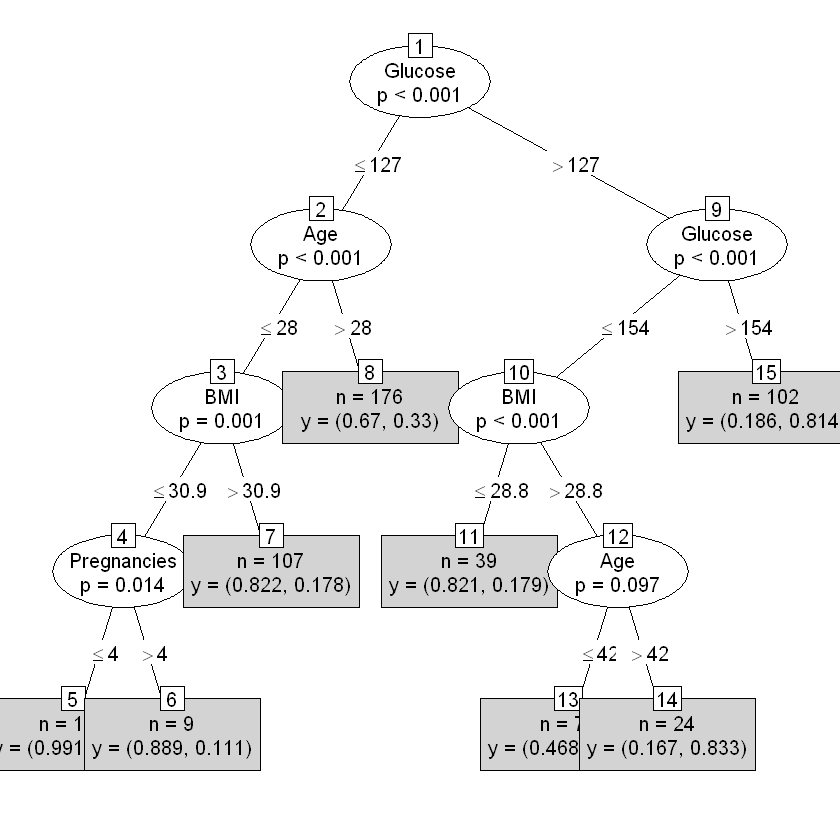

In [160]:
# Find the best set of parameters
CART_pre_search_result <- CART_pre_search_result[order(CART_pre_search_result[,10], decreasing = T),]
CART_pre_search_result
best_criterion <- CART_pre_search_result[1,1]
best_split <- CART_pre_search_result[1,2]
best_depth <- CART_pre_search_result[1,3]

# Construct the best tree
tree_control = ctree_control(mincriterion = best_criterion, minsplit = best_split, maxdepth = best_depth)

# Use the training and validation dataset to train the best tree
CART_trn <- rbind(train, val)

CART_pre <- ctree(Outcome ~ ., data = CART_trn, controls = tree_control)

# Plot the best tree
#plot(CART_pre)
plot(CART_pre, type="simple")
summary(CART_pre)

# A5-diabetes


분류 성능 평가를 보면 post pruning 보다 분류 성능이 tpr측면에서 항상됬지만, tnr은 감소한 것을 알 수 있다. 하지만 위에서도 말했듯이 위 모델에서 중요한 척도는 TPR이기 때문에 그런 측면에서 POST-PRUNING보다 더 성능이 좋다

물론 Before post pruning 모델의 tpr가 셋 중 가장 높으니까 가장 좋다 (auroc 측면도 동일하다)


   CART_pre_prediction
     0  1
  0 69 15
  1 16 22

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
before Post-Pruning,0.7368421,0.7261905,0.5490196,0.7295082,0.7314969,0.6292135
Post-Pruning,0.5000000,0.8571429,0.6129032,0.7459016,0.6546537,0.5507246
Pre-Pruning,0.5789474,0.8214286,0.5945946,0.7459016,0.6896114,0.5866667


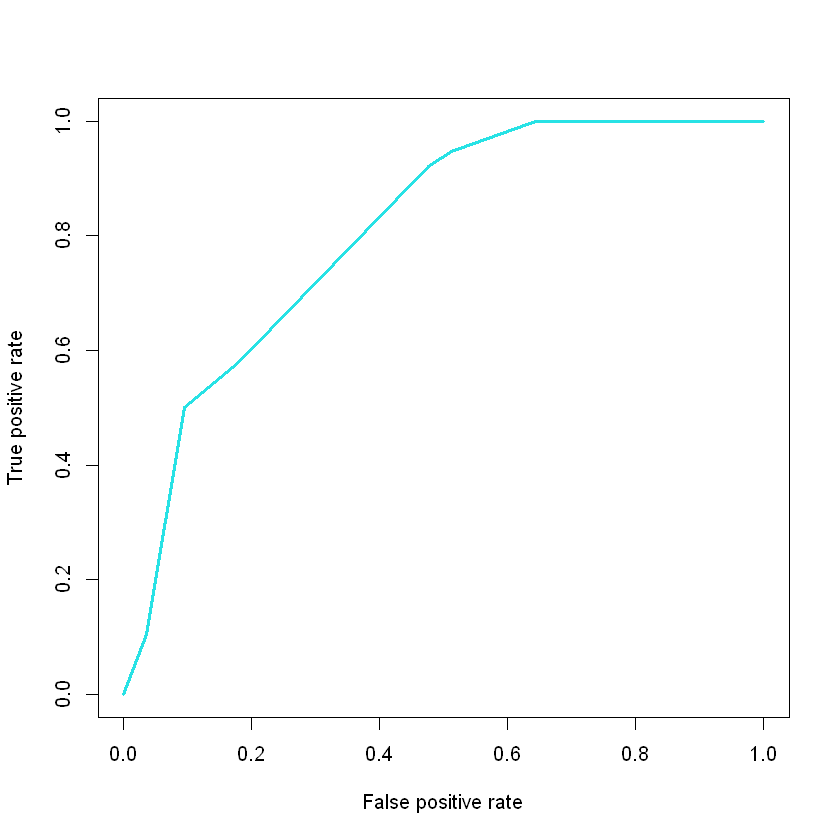

0.7315163
0.6785714
0.7001880


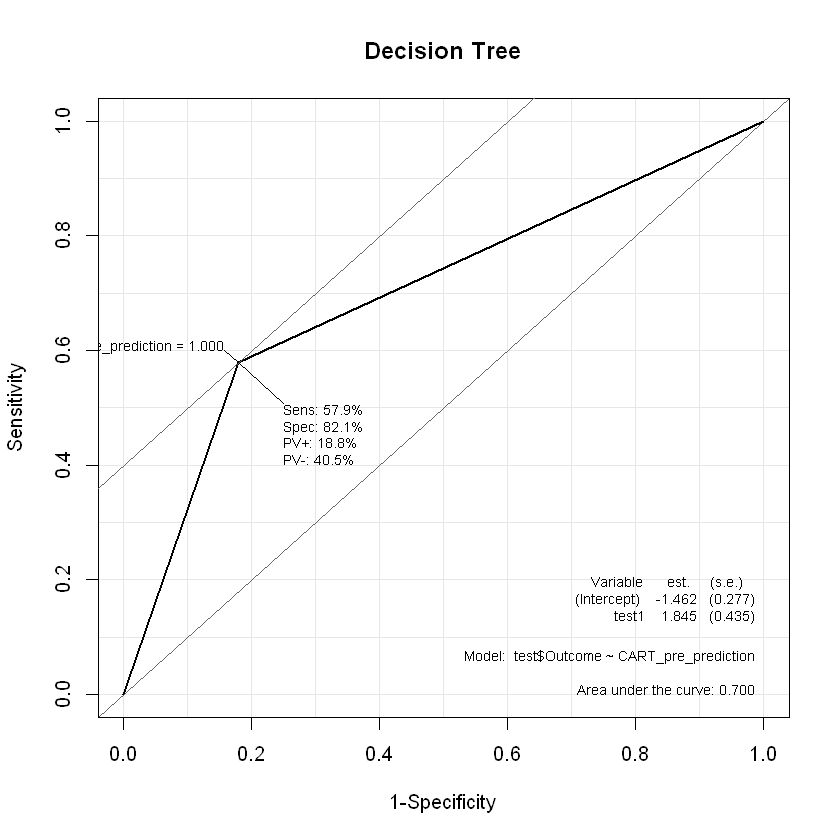

In [197]:
CART_pre_prediction <- predict(CART_pre, newdata = test)
CART_pre_response <- treeresponse(CART_pre, newdata = test)

# Performance of the best tree
CART_pre_cm <- table(test$Outcome, CART_pre_prediction)
CART_pre_cm

Perf_Table[3,] <- perf_eval(CART_pre_cm)
Perf_Table

# Plot the ROC
CART_pre_prob <- 1-unlist(CART_pre_response, use.names=F)[seq(1,nrow(test)*2,2)]
CART_pre_rocr <- prediction(CART_pre_prob, test$Outcome)
CART_pre_perf <- performance(CART_pre_rocr, "tpr","fpr") 
plot(CART_pre_perf, col=5, lwd = 3)


roc <- ROC(test=CART_pre_prediction, stat=test$Outcome, plot="ROC", AUC=T, main="Decision Tree")
AUROC[3,]<-roc$AUC
AUROC

In [162]:
Perf_Table_total[4,] <- Perf_Table[1,] 

# A6 - diabetes : logistic regression


In [163]:

# Train the Logistic Regression Model with all variables
full_lr <- glm(Outcome ~ ., family=binomial, data=train)
summary(full_lr)


Call:
glm(formula = Outcome ~ ., family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6805  -0.7216  -0.3863   0.6974   2.4184  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -8.969676   0.943402  -9.508  < 2e-16 ***
Pregnancies               0.131062   0.041108   3.188  0.00143 ** 
Glucose                   0.042085   0.005001   8.415  < 2e-16 ***
BloodPressure            -0.017545   0.006792  -2.583  0.00980 ** 
SkinThickness             0.003766   0.008478   0.444  0.65686    
Insulin                  -0.002321   0.001100  -2.110  0.03489 *  
BMI                       0.089493   0.019314   4.634 3.59e-06 ***
DiabetesPedigreeFunction  0.955613   0.364444   2.622  0.00874 ** 
Age                       0.014403   0.012323   1.169  0.24249    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null

In [164]:
tst <-rbind(val,test)
lr_response <- predict(full_lr, type = "response", newdata = tst)
lr_target <-tst$Outcome
lr_predicted <- rep(0, length(lr_target))
lr_predicted[which(lr_response >= 0.5)] <- 1
cm_full <- table(lr_target, lr_predicted)
cm_full

         lr_predicted
lr_target   0   1
        0 144  26
        1  38  49

In [165]:
Perf_Table_total[3,]<-perf_eval(cm_full)

# A6

In [166]:
Perf_Table_total

,TPR,Precision,TNR,Accuracy,BCR,F1-Measure
D1_LR,0.6108211,0.9237120,0.7358491,0.8429499,0.7511476,0.6675311
D1_Decision Tree,0.4169041,0.9626168,0.7967332,0.8206965,0.6334973,0.5473815
D2_LR,0.5632184,0.8470588,0.6533333,0.7509728,0.6907091,0.6049383
D2_Decision Tree,0.7368421,0.7261905,0.5490196,0.7295082,0.7314969,0.6292135


위 도표를 해석해보자면, income data는 diabates data 보다 더 변수들간 선형적인 분포를 가져서 위와 같이 logistic regression 값이 더 좋게 
나온 것 같고, 위 데이터가 분산이 커서 decision tree가 overfitting되서 위와 같이 성능이 안좋게 나오지 않았나 생각한다

diabetes를 보면 반대로, 의사결정나무의 평가 지표가 더 좋게 나왔는데, 아마 데이터 자체가 이를 한번에 나눌 수 있는 초평면이 존재하지 않아서 그런
것 같다. 

# A7
각 데이터셋마다 Logistic Regression에 의해 중요하다고 판별된 변수들과 의사결정나무에 의해 중요
하다고 판별된 변수들을 확인해보고 차이가 있는지의 여부와, 차이가 존재할 경우 그 이유에 대한 본인의 생각을 서술해 보시오

### 사용된 변수

1. Data : autistic 
- Logistic Regression : age fnlwgt  education.num   capital.gain capital.loss  hours.per.week workclass marital.status occupation occupation race sex relationship
- Decision Tree : "relationship" "capital.gain" "education"

공통점 : "relationship" "capital.gain" "education"

차이점 : 위 logistic regression에서는 decision tree에 사용되지 않은 age fnlwgt  education.num capital.loss  hours.per.week workclass marital.status occupation occupation race sex relationship 이 사용됬다.

이런 이유가 나타난 원인으로는 데이터가 심하기 불균형하여 decision tree가 학습이 덜 된 것 같다.

2. Data : diabetes
- Logistic Regression : Pregnancies ,Glucose ,BloodPressure, Insulin, BMI, DiabetesPedigreeFunction
- Decision Tree : "Glucose",  "BMI" ,"Age","Insulin"

공통점 : BMI, Glucose, Insulin 이 사용됨

차이점 : *logistic regression* 에서는 Pregnancies, BloodPressure, DiabetesPedigreeFunction 이 추가로 사용됨
*Decision Tree* 는 age가 사용됨

원인 분석

DT 에서 outcome 이 0과 1일떄 분포가 달라서 사용했습니다.







